# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.


This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

from common_utils import set_seed, MLP, CustomDataset, split_dataset, preprocess_dataset, loss_fn 

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [3]:
# YOUR CODE HERE
df = pd.read_csv('simplified.csv')  

df['label'] = df['filename'].apply(lambda x: 1 if '_pos_' in x else 0)  # Binary labels (1 for positive, 0 for negative)


columns_to_drop = ['filename']

df_train, y_train, df_test, y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=42)

X_train_scaled, X_test_scaled = preprocess_dataset(df_train, df_test)

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [ ]:
# def generate_cv_folds_for_batch_sizes(zz, X_train, y_train):
#     """
#     returns:
#     X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
#     X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
#     y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
#     y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
#     """
#     # YOUR CODE HERE
#     return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

# batch_sizes = []
# X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


In [4]:
def generate_cv_folds_for_batch_sizes(batch_sizes, X_train, y_train):
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
        
        for train_idx, val_idx in kf.split(X_train):
            # Split the data
            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
            
            # Standardize the features
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)
            
            X_train_scaled_dict[batch_size].append(X_train_fold_scaled)
            X_val_scaled_dict[batch_size].append(X_val_fold_scaled)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparameter_name):
    cross_validation_accuracies = {}
    cross_validation_times = {}
    
    for batch_size in batch_sizes:
        fold_accuracies = []
        fold_times = []
        
        for fold in range(5):
            # Get train and validation sets for the current fold
            X_train_fold = X_train_scaled_dict[batch_size][fold]
            X_val_fold = X_val_scaled_dict[batch_size][fold]
            y_train_fold = y_train_dict[batch_size][fold]
            y_val_fold = y_val_dict[batch_size][fold]
            
            # Convert to Pytorch Datasets
            train_dataset = CustomDataset(X_train_fold, y_train_fold)
            val_dataset = CustomDataset(X_val_fold, y_val_fold)
            
            # Initialize dataloaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            
            # Define model, optimizer
            model = MLP(no_features=X_train_fold.shape[1], no_hidden=128, no_labels=1)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            
            # Training loop 
            start_time = time.time()
            for epoch in range(10):  # Train for 10 epochs
                model.train()
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    outputs = model(X_batch).squeeze()
                    loss = loss_fn(outputs, y_batch)
                    loss.backward()
                    optimizer.step()
            
            # Evaluate on the validation set
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    outputs = model(X_batch).squeeze()
                    predictions = (outputs > 0.5).float()
                    correct += (predictions == y_batch).sum().item()
                    total += len(y_batch)
            
            accuracy = correct / total
            fold_accuracies.append(accuracy)
            fold_times.append(time.time() - start_time)
        
        # Store mean accuracy and time for the batch size
        cross_validation_accuracies[batch_size] = np.mean(fold_accuracies)
        cross_validation_times[batch_size] = np.mean(fold_times)
    
    return cross_validation_accuracies, cross_validation_times


In [6]:
# Drop columns that are not needed (like filenames) and split the dataset

columns_to_drop = ['filename']

# Split the dataset into training and test sets
df_train, y_train, df_test, y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=42)

# Preprocess the training and test datasets
X_train_scaled, X_test_scaled = preprocess_dataset(df_train, df_test)


In [7]:
# YOUR CODE HERE

batch_sizes = [64, 128, 256, 512]
# Generate cross-validation folds for different batch sizes
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(
    batch_sizes, X_train_scaled, y_train
)
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

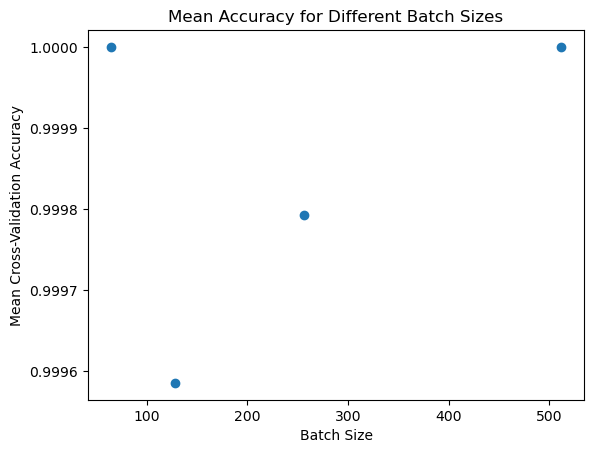

In [8]:
# YOUR CODE HERE
# Plotting the results
plt.scatter(batch_sizes, list(cross_validation_accuracies.values()))
plt.xlabel('Batch Size')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Mean Accuracy for Different Batch Sizes')
plt.show()

4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [9]:
df = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Last Epoch Time (s)': list(cross_validation_times.values())
})

print(df)

   Batch Size  Last Epoch Time (s)
0          64             4.872275
1         128             3.676197
2         256             3.281742
3         512             3.599866


In [ ]:
# YOUR CODE HERE
optimal_batch_size =
reason =

In [10]:
# Selecting the batch size with the highest cross-validation accuracy
optimal_batch_size = max(cross_validation_accuracies, key=cross_validation_accuracies.get)

# Reason for selection
reason = "The batch size of {} is selected because it provides the highest mean cross-validation accuracy with an acceptable training time.".format(optimal_batch_size)

print("Optimal Batch Size:", optimal_batch_size)
print("Reason:", reason)

Optimal Batch Size: 64
Reason: The batch size of 64 is selected because it provides the highest mean cross-validation accuracy with an acceptable training time.
